# ERIS gvAPP PSF

M Kenworthy // 2022 October 05

Generates a FITS file with the correct appearance for the gvAPP in ERIS at a given band and bandwidth.

In [56]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage

def phase_to_PSF(aper,phase,pupil_grid,focal_grid, wlen, bwidth, nwlens=7):
    '''phase_to_PSF - makes the three focal plane PSFS for the ERIS gvAPP coronagraph
    wlen - central wavlength
    bwidth - FWHM of the filter used in the same units as wlen
    nwlens - the number of (equally spaced) wavelength images generated over the bandwidth of the filter'''
    wf_p1 = Wavefront(aper*np.exp(1j*phase)) # Coro PSF 1
    wf_p2 = Wavefront(aper*np.exp(-1j*phase))# Coro PSF 2
    wf_lt = Wavefront(aper) # Leakage Term PSF

    prop = FraunhoferPropagator(pupil_grid, focal_grid)

    focalplane = 0
    fp_p1 = 0
    fp_p2 = 0
    fp_lt = 0
    for wl in np.linspace((wlen-(bwidth/2.))/wlen, \
                          (wlen+(bwidth/2.))/wlen, \
                          nwlens): # normalised to unity wavelength
        wf_p1.wavelength = wl
        wf_p2.wavelength = wl
        wf_lt.wavelength = wl
        fp_p1 += prop(wf_p1).intensity
        fp_p2 += prop(wf_p2).intensity
        fp_lt += prop(wf_lt).intensity
        #focalplane += fp_p1 + fp_p2 +0.02*fp_lt

    Strehl = prop(wf_lt).intensity.max()/prop(wf_p1).intensity.max()

    return(fp_p1, fp_p2, fp_lt) 



In [57]:
vAPP_name = 'ERIS_final_gvAPP.fits.gz'
vAPP = read_fits(vAPP_name)
Pupil_name = 'ERIS_final_amplitude.fits.gz'
Pupil = read_fits(Pupil_name)

NOTE that I've set the sampling to 3.5 manually for fast calculation - to make the actual scale ERIS PSF you need to uncomment the previous line and comment out the 3.5 line.

The (385/406) is an arbitrary ratio measured between the astrometric reference points measured from the ERIS July 2022 commissioning run and picked to make the 4.05um Bra PSF match the measured PSF. 

In [58]:
Npix = vAPP.shape[0]

###wlen0, bwidth, filtname = 3.97, 0.10, "Bra-cont" # central wavelength and FWHM bwidth of the filter (microns)
wlen0, bwidth, filtname = 4.05, 0.02, "Bra" # central wavelength and FWHM bwidth of the filter (microns)
###wlen0, bwidth, filtname = 2.17, 0.02, "Brg" # central wavelength and FWHM bwidth of the filter (microns)

dtel = 8.4 # telescope diameter (meters)
pscale = 12.25 # marcsec / pixel for ERIS

sampling = .206265 * (wlen0 / dtel) / (pscale*1e-3)

sampling = sampling * (385./406.) # 0.95 scale factor empirically measured

print(f'setting the sampling to {sampling} pixels')



pupil_grid = make_pupil_grid(Npix)
focal_grid = make_focal_grid(q=sampling, num_airy=100)

Pupil_flattened = Field(Pupil.ravel(),pupil_grid)
vAPP_flattened = Field(vAPP.ravel(),pupil_grid)
(fp1, fp2, fplt) = phase_to_PSF(Pupil_flattened,vAPP_flattened,pupil_grid,focal_grid, wlen0, bwidth)

setting the sampling to 7.6983895898260775 pixels


Text(0.5, 1.0, 'gvAPP PSF Bra with central wavelength 4.05 microns and bandwidth 0.02 microns')

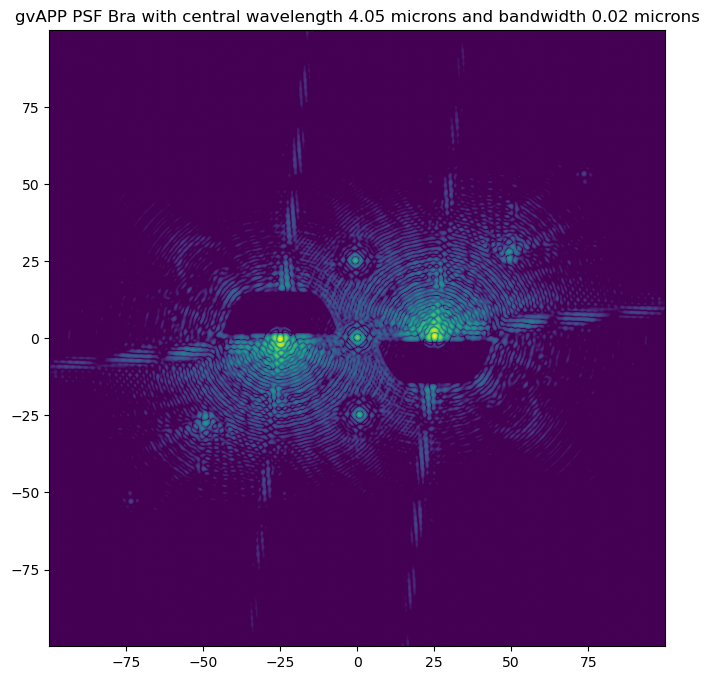

In [59]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

lt_flux_frac = 0.02

p1_flux_frac = 0.5
p2_flux_frac = 0.5

gvapp = (p1_flux_frac-(lt_flux_frac/2.)) * fp1 + \
        (p2_flux_frac-(lt_flux_frac/2.)) * fp2 + \
         lt_flux_frac * fplt
imshow_field(np.log10(gvapp/gvapp.max()),vmin = -5.0,vmax = 0)
ax.set_title(f'gvAPP PSF {filtname} with central wavelength {wlen0} microns and bandwidth {bwidth} microns')

To convert this image from HCIpy to ERIS orientation, we need to convert to a numpy array, flip horizontally, and then rotate the PSF by an angle of about 38 degrees, as measured by MAK on 5 October 2022 using ds9 and the Vector arrows. Visually blinking the two images shows we are within a pixel or two of coalignment.

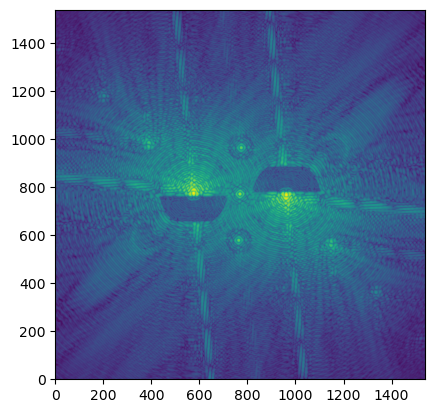

In [82]:
normPSF = (gvapp/gvapp.max()).shaped
# flip the image horizontally
normPSF=normPSF[::-1,:]
plt.imshow(np.log10(normPSF),origin='lower')

In [84]:

normPSFrot = ndimage.rotate(normPSF, 35.85, reshape=False)

hdu2 = fits.PrimaryHDU(normPSFrot)
hdu2.writeto(f'ERIS_gvAPP_PSF_{filtname}_{wlen0}_{bwidth}.fits',overwrite=True)